In [1]:
import pandas as pd
import numpy as np
import os
from scipy.io import loadmat

In [2]:
# Load the CSV file
quality_df = pd.read_csv('Data_Quality_Evaluation.csv', index_col=0)

# Transpose the DataFrame
quality_df = quality_df.T

In [3]:
# Define EEG channels
channels = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2"]

# Function to extract all channels from a .mat file
def get_all_channels_from_mat(file_path):
    """
    Load a .mat file and extract all channels as a NumPy array.
    Returns a 8xTime NumPy array where each row is a channel.
    Returns None if file doesn't exist or has issues.
    """
    try:
        mat_data = loadmat(file_path)
        
        # Use 'ThisEEG' as the data key
        data_key = 'ThisEEG'
        
        if data_key not in mat_data:
            print(f"Warning: 'ThisEEG' key not found in {file_path}")
            return None
        
        # Assume the data is already in 8xTime format
        data_array = mat_data[data_key]
        
        # Return as NumPy array with shape (8, time_points)
        return np.array(data_array, dtype=np.float64)
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


In [5]:
# Build the main DataFrame
# Participants: 1 to 58 (as strings to match quality_df)
# Video clips: 1 to 36

participants = [str(i) for i in range(1, 59)]  # "1" to "58" as strings
video_clips = list(range(1, 37))  # 1 to 36

# Initialize DataFrame with object dtype to store NumPy arrays
eeg_df = pd.DataFrame(index=participants, columns=video_clips, dtype=object)

# Fill the DataFrame
for participant in participants:
    # Convert participant string to P01 format for folder name
    participant_folder = f"P{int(participant):02d}"
    
    for video_id in video_clips:
        file_path = f'EEGData/Movie_{participant_folder}/EEG_Clip{video_id}.mat'
        
        # Get all channels as a NumPy array (8xTime)
        eeg_array = get_all_channels_from_mat(file_path)
        
        if eeg_array is not None:
            eeg_df.at[participant, video_id] = eeg_array
        else:
            eeg_df.at[participant, video_id] = None

In [6]:
# Create cleaned DataFrame based on quality scores
# 1 = perfect, 2 = good, 3 = ok, 4 = problematic, 5 = bad, 6 = missing
# Remove all data with quality score => 3

# Start with a copy of eeg_df
eeg_cleaned_df = eeg_df.copy()

# Iterate through all participants and video clips
for participant in eeg_cleaned_df.index:
    for video_id in eeg_cleaned_df.columns:
        # Check if quality score exists and is > 3
        if participant in quality_df.index and video_id in quality_df.columns:
            quality_score = quality_df.loc[participant, video_id]
            if pd.notna(quality_score) and quality_score > 3:
                # Set the corresponding EEG data to None
                eeg_cleaned_df.at[participant, video_id] = None

In [7]:
from antropy import lziv_complexity

def calculate_lzc(signal, hz=32, epoch_len_sec=2.0):
    """
    signal: array of shape (1, samples) or (samples,)
    hz: sampling rate
    epoch_len_sec: length of epoch to calculate LPZ over
    
    Returns: average Lempel-Ziv complexity across all epochs
    """
    # Ensure signal is 1D
    if len(signal.shape) == 2:
        signal = signal.flatten()
    
    n_samples = len(signal)
    epoch_samples = int(hz * epoch_len_sec)  # number of samples per epoch
    n_epochs = n_samples // epoch_samples  # number of complete epochs
    
    if n_epochs == 0:
        return np.nan
    
    lzc_vals = []
    
    # Calculate LZC for each epoch
    for e in range(n_epochs):
        # Extract epoch
        start_idx = e * epoch_samples
        end_idx = start_idx + epoch_samples
        epoch = signal[start_idx:end_idx]
        
        # Z-score the epoch
        z_scored = (epoch - np.mean(epoch)) / (np.std(epoch) + 1e-9)
        
        # Binarize (threshold at 0)
        binarized = (z_scored > 0).astype(int)
        
        # Calculate Lempel-Ziv complexity
        lzc = lziv_complexity(binarized)
        lzc_vals.append(lzc)
    
    # Return average LZC across all epochs
    return np.mean(lzc_vals)

In [8]:
# Calculate LZC for all cells in eeg_cleaned_df
# Create a new DataFrame with the same shape
lzc_df = pd.DataFrame(index=eeg_cleaned_df.index, columns=eeg_cleaned_df.columns, dtype=object)

# Iterate through all participants and video clips
for participant in eeg_cleaned_df.index:
    for video_id in eeg_cleaned_df.columns:
        eeg_data = eeg_cleaned_df.at[participant, video_id]
        
        # If the cell is None, keep it None
        if eeg_data is None:
            lzc_df.at[participant, video_id] = None
        else:
            # eeg_data is an 8xTime NumPy array
            # Calculate LZC for each of the 8 channels
            lzc_values = []
            
            for channel_idx in range(8):
                # Extract the channel data (one row from the 8xTime array)
                channel_signal = eeg_data[channel_idx, :]
                
                # Calculate LZC for this channel
                lzc = calculate_lzc(channel_signal, hz=32, epoch_len_sec=2.0)
                lzc_values.append(lzc)
            
            # Store as NumPy array (NaN values will be preserved)
            lzc_df.at[participant, video_id] = np.array(lzc_values, dtype=np.float64)

In [17]:
# Count the number of non-None cells for each participant
valid_trial_counts = lzc_df.notna().sum(axis=1)
valid_trial_counts_dict = valid_trial_counts.to_dict()

# Make a list of participants with less than 3 valid trials
participants_with_less_than_3_valid_trials = [participant for participant, count in valid_trial_counts_dict.items() if count < 3]

# Filter out rows with participants with less than 3 valid trials
lzc_filtered_df = lzc_df[~lzc_df.index.isin(participants_with_less_than_3_valid_trials)]

# Filter to participants 1-36 (as strings)
participants_1_to_36 = [str(i) for i in range(1, 37)]
lzc_filtered_df = lzc_filtered_df[lzc_filtered_df.index.isin(participants_1_to_36)]

lzc_filtered_df

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,"[8.0, 3.0588235294117645, 3.1176470588235294, ...","[8.363636363636363, 2.878787878787879, 2.84848...","[8.666666666666666, 3.4444444444444446, 3.2592...",None,"[8.9, 3.32, 3.22, 2.8, 2.62, 3.34, 3.14, 3.16]",None,"[7.177777777777778, 2.2, 2.2444444444444445, 2...",None,"[8.571428571428571, 3.2285714285714286, 3.3142...",None,...,None,"[8.295454545454545, 3.3863636363636362, 3.4545...","[8.186046511627907, 2.883720930232558, 2.67441...",None,"[7.140625, 2.84375, 2.828125, 2.828125, 2.8281...",None,"[8.793103448275861, 3.3275862068965516, 3.4655...","[8.6, 3.1333333333333333, 3.2333333333333334, ...",None,"[8.35483870967742, 3.0, 3.032258064516129, 3.0..."
2,"[8.176470588235293, 3.235294117647059, 3.21568...",None,None,"[8.261904761904763, 3.1666666666666665, 3.3333...","[8.46, 3.18, 3.24, 3.06, 3.08, 3.02, 3.02, 3.06]",None,"[8.355555555555556, 3.4, 3.2666666666666666, 2...","[8.242424242424242, 3.1818181818181817, 3.0909...","[8.714285714285714, 3.2, 3.1142857142857143, 3...","[8.222222222222221, 3.0444444444444443, 3.1777...",...,"[8.17142857142857, 3.0285714285714285, 3.14285...","[8.318181818181818, 3.1363636363636362, 3.2727...","[8.767441860465116, 3.3255813953488373, 3.2790...","[8.256410256410257, 2.8461538461538463, 2.6923...","[8.640625, 3.171875, 3.265625, 3.21875, 3.1406...","[8.185185185185185, 3.1481481481481484, 3.1481...","[8.551724137931034, 3.3448275862068964, 3.2758...","[7.9, 3.0, 2.9, 3.066666666666667, 3.033333333...","[8.444444444444445, 3.1555555555555554, 3.2, 3...","[8.387096774193548, 3.161290322580645, 3.29032..."
3,"[8.509803921568627, 3.176470588235294, 3.29411...","[8.606060606060606, 3.121212121212121, 3.30303...","[8.814814814814815, 3.3333333333333335, 3.1481...","[7.857142857142857, 3.261904761904762, 3.33333...","[7.12, 3.28, 3.16, 3.08, 3.18, 3.16, 3.18, 3.08]","[7.0, 3.423076923076923, 3.3076923076923075, 3...","[7.2, 3.2888888888888888, 3.3333333333333335, ...","[8.181818181818182, 3.272727272727273, 3.36363...","[7.085714285714285, 3.085714285714286, 3.14285...","[8.11111111111111, 3.2444444444444445, 3.15555...",...,"[8.6, 3.3142857142857145, 3.2285714285714286, ...",None,"[7.744186046511628, 3.186046511627907, 3.34883...","[8.564102564102564, 3.1538461538461537, 3.3589...","[8.234375, 3.265625, 3.390625, 3.21875, 3.2031...","[8.11111111111111, 3.259259259259259, 3.148148...","[8.53448275862069, 3.2758620689655173, 3.29310...","[8.466666666666667, 3.2333333333333334, 3.4, 3...","[7.688888888888889, 3.022222222222222, 3.15555...","[7.645161290322581, 3.129032258064516, 3.06451..."
4,"[7.8431372549019605, 3.2941176470588234, 3.254...","[8.242424242424242, 3.212121212121212, 3.12121...","[7.962962962962963, 3.4074074074074074, 3.2592...","[7.738095238095238, 3.119047619047619, 3.16666...","[7.46, 3.36, 3.22, 3.18, 3.22, 3.12, 3.2, 3.06]","[7.8076923076923075, 3.076923076923077, 3.1923...","[7.111111111111111, 3.066666666666667, 3.02222...","[7.878787878787879, 3.272727272727273, 3.42424...","[7.942857142857143, 3.2857142857142856, 3.1142...","[8.177777777777777, 3.2444444444444445, 3.2888...",...,"[8.0, 2.6285714285714286, 3.342857142857143, 2...","[8.204545454545455, 3.2954545454545454, 3.4318...","[7.744186046511628, 3.395348837209302, 3.37209...","[8.076923076923077, 3.3846153846153846, 3.4358...","[7.890625, 2.6875, 2.609375, 2.96875, 2.921875...","[8.25925925925926, 3.2962962962962963, 3.37037...","[7.224137931034483, 2.7758620689655173, 2.7413...","[7.233333333333333, 3.3, 3.1666666666666665, 3...","[8.28888888888889, 3.2, 3.2888888888888888, 2....",None
5,None,None,None,"[5.9523809523809526, 3.1666666666666665, 3.238...","[5.88, 2.28, 2.26, 2.24, 2.28, 2.28, 2.18, 2.32]",None,None,None,None,None,...,None,"[7.681818181818182, 2.909090909090909, 2.86363...",None,"[8.0, 2.923076923076923, 2.8205128205128207, 2...","[7.140625, 2.890625, 2.84375, 2.9375, 2.84375,...","[8.407407407407407, 2.814814814814815, 2.75925...","[8.5, 3.05

In [47]:
# Filter participant_mean_lzc_df to only include participants 1-36
participants_1_to_36 = [str(i) for i in range(1, 37)]
participant_mean_lzc_df_1_to_36 = participant_mean_lzc_df.loc[participant_mean_lzc_df.index.intersection(participants_1_to_36)]

participant_mean_lzc_df_1_to_36

,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2
1,8.294353,3.059360,3.042115,3.032437,3.050291,3.020558,3.044040,3.031411
2,8.276642,3.124945,3.168349,3.056229,3.068867,3.013155,3.108805,3.118180
3,8.011520,3.233364,3.234732,3.165413,3.164423,3.045352,3.179710,3.148939
4,7.809252,3.181674,3.227305,3.139106,3.125650,3.135397,3.149707,3.112407
5,7.434075,2.875605,2.848425,2.889227,2.857680,2.820703,2.922773,2.921347
6,7.235566,2.665344,2.689426,2.804427,2.000000,2.760387,2.000000,2.774899
7,8.255093,2.967559,2.978760,2.850816,3.030078,2.894845,2.925311,2.965194
8,8.091651,3.191324,3.188345,2.986765,3.036135,3.104512,3.087578,3.047605
10,8.200836,3.106982,3.125568,3.127073,3.162925,3.056578,3.195773,3.111749
11,8.166004,2.968934,2.939399,2.887237,2.768522,2.821710,2.774203,2.963390


In [48]:
# Create a new table with participants 1-36 and their mean LZC for gamma1 and gamma2 only
# Average of gamma1 and gamma2 (excluding beta waves)

# Filter to participants 1-36 (as strings)
participants_1_to_36 = [str(i) for i in range(1, 37)]

# Filter participant_mean_lzc_df to only include participants 1-36
filtered_participants = participant_mean_lzc_df.index.intersection(participants_1_to_36)
participant_mean_lzc_subset = participant_mean_lzc_df.loc[filtered_participants]

# Calculate mean of gamma1 and gamma2 for each participant
gamma_channels = ['gamma1', 'gamma2']
participant_gamma_mean = participant_mean_lzc_subset[gamma_channels].mean(axis=1)

# Create a DataFrame with participants as rows and the mean LZC as a column
participant_gamma_mean_df = pd.DataFrame({
    'Mean_LZC_Gamma': participant_gamma_mean
}, index=filtered_participants)

participant_gamma_mean_df

,Mean_LZC_Gamma
1,3.037726
2,3.113492
3,3.164324
4,3.131057
5,2.922060
6,2.387449
7,2.945252
8,3.067591
10,3.153761
11,2.868796


In [18]:
# Load Arousal.csv
# First column as row indices, first row as column labels
arousal_df = pd.read_csv('Arousal.csv', index_col=0, header=0)
arousal_df = arousal_df.T

In [20]:
# Create arousal_filtered_df by filtering arousal_df based on lzc_filtered_df
# Wherever lzc_filtered_df has None, set the corresponding cell in arousal_filtered_df to NaN

# Convert index to strings to match lzc_filtered_df
arousal_df.index = arousal_df.index.astype(str)

# Filter to only include participants that are in lzc_filtered_df
matching_participants = arousal_df.index.intersection(lzc_filtered_df.index)
arousal_df_filtered = arousal_df.loc[matching_participants].copy()

# Ensure columns are 1-36 (video clips) and in the same order
arousal_df_filtered = arousal_df_filtered.reindex(columns=range(1, 37))

# Now, for each cell where lzc_filtered_df has None, set the corresponding cell to NaN
for participant in arousal_df_filtered.index:
    for video_id in arousal_df_filtered.columns:
        # Check if lzc_filtered_df has None at this position
        if participant in lzc_filtered_df.index and video_id in lzc_filtered_df.columns:
            lzc_value = lzc_filtered_df.at[participant, video_id]
            if lzc_value is None:
                arousal_df_filtered.at[participant, video_id] = np.nan

arousal_filtered_df = arousal_df_filtered

In [22]:
# Create a combined dataframe with all data needed for analysis
# Columns: Participant_ID, Video_ID, Arousal, and 8 LZC channel scores (NO Valence)

# Define channels
channels = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2"]

# Initialize list to store rows
rows = []

# Iterate through all participant/video combinations in lzc_filtered_df
for participant in lzc_filtered_df.index:
    for video_id in lzc_filtered_df.columns:
        # Get LZC array for this trial
        lzc_array = lzc_filtered_df.at[participant, video_id]
        
        # Skip if None
        if lzc_array is None:
            continue
        
        # Initialize row dictionary
        row = {
            'Participant_ID': participant,
            'Video_ID': video_id
        }
        
        # Get Arousal from arousal_filtered_df
        if participant in arousal_filtered_df.index and video_id in arousal_filtered_df.columns:
            arousal_val = arousal_filtered_df.at[participant, video_id]
            row['Arousal'] = arousal_val if not np.isnan(arousal_val) else np.nan
        else:
            row['Arousal'] = np.nan
        
        # Get LZC scores for each channel
        if isinstance(lzc_array, np.ndarray) and len(lzc_array) == 8:
            for channel_idx, channel_name in enumerate(channels):
                lzc_val = lzc_array[channel_idx]
                row[channel_name] = lzc_val if not np.isnan(lzc_val) else np.nan
        else:
            # If array is not valid, set all channels to NaN
            for channel_name in channels:
                row[channel_name] = np.nan
        
        # Add row to list
        rows.append(row)

# Create DataFrame from list of rows
combined_df = pd.DataFrame(rows)

# Reorder columns: Participant_ID, Video_ID, Arousal, then 8 channels (NO Valence)
column_order = ['Participant_ID', 'Video_ID', 'Arousal'] + channels
combined_df = combined_df[column_order]

combined_df


,Participant_ID,Video_ID,Arousal,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2
0,1,1,1.0,8.000000,3.058824,3.117647,3.117647,2.960784,3.117647,3.058824,3.156863
1,1,2,3.0,8.363636,2.878788,2.848485,3.060606,3.030303,2.757576,3.030303,3.000000
2,1,3,1.0,8.666667,3.444444,3.259259,3.148148,3.296296,2.962963,3.185185,3.074074
3,1,5,4.0,8.900000,3.320000,3.220000,2.800000,2.620000,3.340000,3.140000,3.160000
4,1,7,3.0,7.177778,2.200000,2.244444,2.466667,2.555556,2.777778,2.422222,2.777778
...,...,...,...,...,...,...,...,...,...,...,...
860,36,32,4.0,8.851852,2.000000,3.259259,3.407407,3.222222,3.370370,3.129630,3.351852
861,36,33,5.0,8.620690,2.000000,3.362069,3.293103,2.948276,3.051724,3.051724,3.034483
862,36,34,5.0,8.733333,2.000000,3.233333,3.233333,3.266667,3.300000,3.066667,2.600000
863,36,35,4.0,8.622222,2.000000,3.266667,3.355556,3.111111,3.133333,2.755556,3.088889


In [23]:
# Create the alpha_mean column as the mean of alpha1 and alpha2 for each row (trial)
combined_df['alpha_mean'] = combined_df[['alpha1', 'alpha2']].mean(axis=1)

In [71]:
import statsmodels.formula.api as smf

# Make sure these columns exist as you showed:
# Participant_ID, Video_ID, Arousal, beta1

# Treat arousal as numeric 1–7
combined_df["Arousal"] = combined_df["Arousal"].astype(float)

# Linear mixed model: random intercept for participant, fixed effects for beta1 and Video_ID
model = smf.mixedlm(
    "Arousal ~ beta1 + C(Video_ID)",   # fixed effects
    data=combined_df,
    groups=combined_df["Participant_ID"]        # random intercept for participants
)
result = model.fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Arousal   
No. Observations:   865      Method:              REML      
No. Groups:         32       Scale:               1.3414    
Min. group size:    4        Log-Likelihood:      -1381.3061
Max. group size:    36       Converged:           Yes       
Mean group size:    27.0                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          3.342    0.634  5.268 0.000  2.098  4.585
C(Video_ID)[T.2]  -0.251    0.327 -0.768 0.442 -0.892  0.390
C(Video_ID)[T.3]  -0.074    0.323 -0.229 0.819 -0.706  0.559
C(Video_ID)[T.4]   0.285    0.316  0.901 0.367 -0.335  0.904
C(Video_ID)[T.5]   0.661    0.323  2.044 0.041  0.027  1.294
C(Video_ID)[T.6]  -0.205    0.339 -0.604 0.546 -0.869  0.459
C(Video_ID)[T.7]  -0.041    0.326 -0

In [72]:
# Mixed-effects regression for each EEG frequency band
# For each band, fit two models: one predicting Valence and one predicting Arousal
# Each model has: fixed effect for the band, random intercepts for Participant_ID and Video_ID

from statsmodels.regression.mixed_linear_model import MixedLM
import warnings
from IPython.display import display, HTML
warnings.filterwarnings('ignore')

# Define the 8 frequency bands + mean of beta1, beta2, gamma1, and gamma2
bands = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2", "mean_beta_gamma", "alpha_mean"]

# Store results for all models
results_summary = []

# Loop over all frequency bands
for band in bands:
    print(f"\n{'='*80}")
    print(f"FREQUENCY BAND: {band.upper()}")
    print(f"{'='*80}\n")
    
    # Prepare data for this band - drop rows with missing values for this band and outcome
    # We'll fit two models, so prepare data separately for each
    
    # Model 1: Valence
    print(f"--- Model 1: Predicting Valence from {band} ---")
    data_valence = combined_df[['Participant_ID', 'Video_ID', 'Valence', band]].copy()
    data_valence = data_valence.dropna(subset=['Valence', band])
    
    if len(data_valence) > 0:
        # Fit mixed-effects model with random intercept for Participant_ID
        # Note: For crossed random effects (Participant_ID and Video_ID), 
        # we'll fit separate models for each grouping variable
        # and also create a combined model
        
        # Model with Participant_ID as random effect
        model_valence_participant = MixedLM(
            endog=data_valence['Valence'],
            exog=data_valence[[band]],
            groups=data_valence['Participant_ID']
        )
        result_valence_participant = model_valence_participant.fit()
        
        # Model with Video_ID as random effect
        model_valence_video = MixedLM(
            endog=data_valence['Valence'],
            exog=data_valence[[band]],
            groups=data_valence['Video_ID']
        )
        result_valence_video = model_valence_video.fit()
        
        # Store results
        results_summary.append({
            'Band': band,
            'Outcome': 'Valence',
            'Grouping': 'Participant_ID',
            'Coefficient': result_valence_participant.fe_params[band],
            'SE': result_valence_participant.bse[band],
            'P-value': result_valence_participant.pvalues[band],
            'N': len(data_valence),
            'AIC': result_valence_participant.aic,
            'BIC': result_valence_participant.bic
        })
        
        results_summary.append({
            'Band': band,
            'Outcome': 'Valence',
            'Grouping': 'Video_ID',
            'Coefficient': result_valence_video.fe_params[band],
            'SE': result_valence_video.bse[band],
            'P-value': result_valence_video.pvalues[band],
            'N': len(data_valence),
            'AIC': result_valence_video.aic,
            'BIC': result_valence_video.bic
        })
        
        # Print fixed-effect summary for Participant_ID model
        print(f"\nFixed Effects (Random Intercept: Participant_ID):")
        print(result_valence_participant.summary().tables[1])
        
        # Print fixed-effect summary for Video_ID model
        print(f"\nFixed Effects (Random Intercept: Video_ID):")
        print(result_valence_video.summary().tables[1])
    else:
        print("Insufficient data for Valence model")
    
    # Model 2: Arousal
    print(f"\n--- Model 2: Predicting Arousal from {band} ---")
    data_arousal = combined_df[['Participant_ID', 'Video_ID', 'Arousal', band]].copy()
    data_arousal = data_arousal.dropna(subset=['Arousal', band])
    
    if len(data_arousal) > 0:
        # Model with Participant_ID as random effect
        model_arousal_participant = MixedLM(
            endog=data_arousal['Arousal'],
            exog=data_arousal[[band]],
            groups=data_arousal['Participant_ID']
        )
        result_arousal_participant = model_arousal_participant.fit()
        
        # Model with Video_ID as random effect
        model_arousal_video = MixedLM(
            endog=data_arousal['Arousal'],
            exog=data_arousal[[band]],
            groups=data_arousal['Video_ID']
        )
        result_arousal_video = model_arousal_video.fit()
        
        # Store results
        results_summary.append({
            'Band': band,
            'Outcome': 'Arousal',
            'Grouping': 'Participant_ID',
            'Coefficient': result_arousal_participant.fe_params[band],
            'SE': result_arousal_participant.bse[band],
            'P-value': result_arousal_participant.pvalues[band],
            'N': len(data_arousal),
            'AIC': result_arousal_participant.aic,
            'BIC': result_arousal_participant.bic
        })
        
        results_summary.append({
            'Band': band,
            'Outcome': 'Arousal',
            'Grouping': 'Video_ID',
            'Coefficient': result_arousal_video.fe_params[band],
            'SE': result_arousal_video.bse[band],
            'P-value': result_arousal_video.pvalues[band],
            'N': len(data_arousal),
            'AIC': result_arousal_video.aic,
            'BIC': result_arousal_video.bic
        })
        
        # # Print fixed-effect summary for Participant_ID model
        # print(f"\nFixed Effects (Random Intercept: Participant_ID):")
        # print(result_arousal_participant.summary().tables[1])
        
        # # Print fixed-effect summary for Video_ID model
        # print(f"\nFixed Effects (Random Intercept: Video_ID):")
        # print(result_arousal_video.summary().tables[1])

        # In your loop, instead of print(), use:
        display(HTML(f"<h3>Band: {band.upper()}, Outcome: Valence, Grouping: Participant_ID</h3>"))
        display(result_valence_participant.summary())
    else:
        print("Insufficient data for Arousal model")

# Create summary DataFrame
results_df = pd.DataFrame(results_summary)

print(f"\n\n{'='*80}")
print("SUMMARY OF ALL MODELS")
print(f"{'='*80}\n")

# Use display() instead of print() for DataFrames to avoid truncation
display(results_df)


FREQUENCY BAND: DELTA

--- Model 1: Predicting Valence from delta ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
delta      0.015    0.009  1.632  0.103  -0.003  0.033
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
delta      0.019    0.027  0.716  0.474  -0.033  0.072
Group Var  1.988    0.465                             

--- Model 2: Predicting Arousal from delta ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0051    
Min. group size:  4       Log-Likelihood:     -1713.7090
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
delta       0.015     0.009  1.632  0.103  -0.003   0.033
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: THETA

--- Model 1: Predicting Valence from theta ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
theta      0.040    0.024  1.647  0.099  -0.008  0.087
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
theta      0.006    0.059  0.105  0.916  -0.109  0.121
Group Var  1.982    0.462                             

--- Model 2: Predicting Arousal from theta ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0046    
Min. group size:  4       Log-Likelihood:     -1712.7076
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
theta       0.040     0.024  1.647  0.099  -0.008   0.087
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: ALPHA1

--- Model 1: Predicting Valence from alpha1 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha1     0.040    0.024  1.681  0.093  -0.007  0.086
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha1     0.005    0.068  0.075  0.940  -0.128  0.138
Group Var  1.996    0.469                             

--- Model 2: Predicting Arousal from alpha1 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0045    
Min. group size:  4       Log-Likelihood:     -1712.6811
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
alpha1      0.040     0.024  1.681  0.093  -0.007   0.086
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: ALPHA2

--- Model 1: Predicting Valence from alpha2 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha2     0.042    0.024  1.711  0.087  -0.006  0.089
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha2     0.046    0.071  0.644  0.520  -0.093  0.184
Group Var  1.985    0.464                             

--- Model 2: Predicting Arousal from alpha2 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0044    
Min. group size:  4       Log-Likelihood:     -1712.5991
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
alpha2      0.042     0.024  1.711  0.087  -0.006   0.089
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: BETA1

--- Model 1: Predicting Valence from beta1 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
beta1      0.041    0.024  1.689  0.091  -0.007  0.089
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
beta1      0.036    0.069  0.520  0.603  -0.100  0.172
Group Var  1.983    0.463                             

--- Model 2: Predicting Arousal from beta1 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0046    
Min. group size:  4       Log-Likelihood:     -1712.6357
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
beta1       0.041     0.024  1.689  0.091  -0.007   0.089
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: BETA2

--- Model 1: Predicting Valence from beta2 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
beta2      0.042    0.025  1.685  0.092  -0.007  0.091
Group Var  0.063    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
beta2      0.087    0.073  1.190  0.234  -0.057  0.231
Group Var  2.005    0.473                             

--- Model 2: Predicting Arousal from beta2 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0054    
Min. group size:  4       Log-Likelihood:     -1712.6236
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
beta2       0.042     0.025  1.685  0.092  -0.007   0.091
Group Var   0.063     0.025                              
========================================================

"""


FREQUENCY BAND: GAMMA1

--- Model 1: Predicting Valence from gamma1 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
gamma1     0.041    0.024  1.689  0.091  -0.007  0.089
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
gamma1     0.037    0.070  0.532  0.595  -0.100  0.174
Group Var  1.983    0.463                             

--- Model 2: Predicting Arousal from gamma1 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0046    
Min. group size:  4       Log-Likelihood:     -1712.6322
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
gamma1      0.041     0.024  1.689  0.091  -0.007   0.089
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: GAMMA2

--- Model 1: Predicting Valence from gamma2 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
gamma2     0.041    0.024  1.663  0.096  -0.007  0.089
Group Var  0.064    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
gamma2     0.048    0.074  0.645  0.519  -0.098  0.193
Group Var  1.990    0.466                             

--- Model 2: Predicting Arousal from gamma2 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0051    
Min. group size:  4       Log-Likelihood:     -1712.6757
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
gamma2      0.041     0.024  1.663  0.096  -0.007   0.089
Group Var   0.064     0.025                              
========================================================

"""


FREQUENCY BAND: MEAN_BETA_GAMMA

--- Model 1: Predicting Valence from mean_beta_gamma ---

Fixed Effects (Random Intercept: Participant_ID):
                 Coef. Std.Err.      z  P>|z|  [0.025 0.975]
mean_beta_gamma  0.041    0.025  1.684  0.092  -0.007  0.089
Group Var        0.064    0.025                             

Fixed Effects (Random Intercept: Video_ID):
                 Coef. Std.Err.      z  P>|z|  [0.025 0.975]
mean_beta_gamma  0.055    0.074  0.746  0.456  -0.090  0.201
Group Var        1.991    0.467                             

--- Model 2: Predicting Arousal from mean_beta_gamma ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0049    
Min. group size:  4       Log-Likelihood:     -1712.6360
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
mean_beta_gamma 0.041    0.025 1.684 0.092 -0.007  0.089
Group Var       0.064    0.025                          
========================================================

"""


FREQUENCY BAND: ALPHA_MEAN

--- Model 1: Predicting Valence from alpha_mean ---

Fixed Effects (Random Intercept: Participant_ID):
            Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha_mean  0.041    0.024  1.698  0.090  -0.006  0.088
Group Var   0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
            Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha_mean  0.026    0.071  0.362  0.717  -0.113  0.165
Group Var   1.989    0.466                             

--- Model 2: Predicting Arousal from alpha_mean ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0044    
Min. group size:  4       Log-Likelihood:     -1712.6365
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
alpha_mean  0.041     0.024  1.698  0.090  -0.006   0.088
Group Var   0.065     0.025                              
========================================================

"""



SUMMARY OF ALL MODELS



,Band,Outcome,Grouping,Coefficient,SE,P-value,N,AIC,BIC
0,delta,Valence,Participant_ID,0.014892,0.009125,1.026836e-01,865,NaN,NaN
1,delta,Valence,Video_ID,0.019202,0.026801,4.737130e-01,865,NaN,NaN
2,delta,Arousal,Participant_ID,0.448550,0.012203,9.293750e-296,865,NaN,NaN
3,delta,Arousal,Video_ID,0.444141,0.010843,0.000000e+00,865,NaN,NaN
4,theta,Valence,Participant_ID,0.039794,0.024155,9.946908e-02,865,NaN,NaN
5,theta,Valence,Video_ID,0.006187,0.058751,9.161304e-01,865,NaN,NaN
6,theta,Arousal,Participant_ID,1.157558,0.039061,5.299832e-193,865,NaN,NaN
7,theta,Arousal,Video_ID,1.106501,0.041835,3.745014e-154,865,NaN,NaN
8,alpha1,Valence,Participant_ID,0.039532,0.023520,9.280890e-02,865,NaN,NaN
9,alpha1,Valence,Video_ID,0.005103,0.068007,9.401798e-01,865,NaN,NaN


In [74]:
import statsmodels.formula.api as smf

bands = ["delta", "theta", "alpha1", "alpha2",
            "beta1", "beta2", "gamma1", "gamma2",
            "mean_beta_gamma", "alpha_mean"]

outcomes = ["Valence", "Arousal"]

results = []

for band in bands:
    for outcome in outcomes:
        # Keep only the columns we need for this model
        model_df = combined_df[["Participant_ID", "Video_ID", outcome, band]].copy()
        model_df = model_df.dropna(subset=[outcome, band])
        
        if model_df.empty:
            continue
        
        # Formula: Outcome ~ band + C(Video_ID)
        formula = f"{outcome} ~ {band} + C(Video_ID)"
        
        # Mixed model: random intercept for Participant_ID
        model = smf.mixedlm(formula, data=model_df, groups=model_df["Participant_ID"])
        result = model.fit(reml=True)  # reml=True is default; OK for comparing effects
        
        # Extract the band coefficient info
        coef = result.params[band]
        se = result.bse[band]
        p = result.pvalues[band]
        
        # Store in results list
        results.append({
            "Band": band,
            "Outcome": outcome,
            "Grouping": "Participant_ID (random) + Video_ID (fixed)",
            "Coefficient": coef,
            "SE": se,
            "P-value": p,
            "N": len(model_df),
            "AIC": result.aic,
            "BIC": result.bic
        })

# Turn into a nice summary DataFrame
results_df = pd.DataFrame(results)

# Optional: sort for readability
results_df = results_df.sort_values(by=["Outcome", "Band"]).reset_index(drop=True)

results_df

,Band,Outcome,Grouping,Coefficient,SE,P-value,N,AIC,BIC
0,alpha1,Arousal,Participant_ID (random) + Video_ID (fixed),0.004396,0.203551,0.982770,865,NaN,NaN
1,alpha2,Arousal,Participant_ID (random) + Video_ID (fixed),0.117283,0.225365,0.602777,865,NaN,NaN
2,alpha_mean,Arousal,Participant_ID (random) + Video_ID (fixed),0.084564,0.264642,0.749316,865,NaN,NaN
3,beta1,Arousal,Participant_ID (random) + Video_ID (fixed),0.200399,0.194980,0.304047,865,NaN,NaN
4,beta2,Arousal,Participant_ID (random) + Video_ID (fixed),0.004361,0.230953,0.984936,865,NaN,NaN
5,delta,Arousal,Participant_ID (random) + Video_ID (fixed),0.017797,0.097722,0.855488,865,NaN,NaN
6,gamma1,Arousal,Participant_ID (random) + Video_ID (fixed),0.223141,0.217298,0.304473,865,NaN,NaN
7,gamma2,Arousal,Participant_ID (random) + Video_ID (fixed),0.088427,0.327925,0.787424,865,NaN,NaN
8,mean_beta_gamma,Arousal,Participant_ID (random) + Video_ID (fixed),0.302405,0.333020,0.363842,865,NaN,NaN
9,theta,Arousal,Participant_ID (random) + Video_ID (fixed),-0.094811,0.176215,0.590547,865,NaN,NaN


In [ ]:
# Aggregation dictionary for all target columns
agg_dict = {
    "Arousal": lambda x: np.nan,  # placeholder, will fill below
    "Valence": lambda x: np.nan,
    "Participant_ID": "nunique",  # how many people rated each video
}
for band in bands:
    agg_dict[band] = lambda x: np.nan

def remove_outliers_and_mean(series, z_thresh=2.5):
    vals = series.dropna()
    if len(vals) == 0:
        return np.nan
    z = np.abs((vals - vals.mean()) / vals.std(ddof=0))
    filtered = vals[z <= z_thresh]
    if len(filtered) == 0:
        return np.nan
    return filtered.mean()

agg_dict["Arousal"] = remove_outliers_and_mean
agg_dict["Valence"] = remove_outliers_and_mean
for band in bands:
    agg_dict[band] = remove_outliers_and_mean

combined_per_video_df = combined_df.groupby("Video_ID").agg(agg_dict).reset_index()

# Rename columns for clarity
combined_per_video_df = combined_per_video_df.rename(columns={
    "Arousal": "Arousal_mean",
    "Valence": "Valence_mean",
    "Participant_ID": "N_participants"
})

combined_per_video_df

,Video_ID,Arousal_mean,Valence_mean,N_participants,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2,mean_beta_gamma,alpha_mean
0,1,4.038462,1.814815,27,8.290347,3.134902,3.199849,3.107843,3.097255,3.045249,3.123366,3.096531,3.078431,3.180784
1,2,3.708333,1.291667,24,8.446970,3.304408,3.305665,3.184453,3.198946,3.117260,3.198232,3.132576,3.152146,3.233202
2,3,3.880000,1.080000,25,8.307099,3.260870,3.231481,3.168210,3.141975,3.034074,3.188406,3.121914,3.110340,3.193673
3,4,4.384615,1.461538,27,8.183150,3.215238,3.270147,3.146520,3.110806,3.052910,3.102564,3.119963,3.114286,3.208333
4,5,4.600000,1.720000,25,8.288333,3.224348,3.246667,3.108333,3.118333,3.030833,3.131667,3.100833,3.095417,3.177500
5,6,3.761905,1.571429,21,8.457490,3.283401,3.291209,3.113553,3.128205,2.994231,3.135531,3.080586,3.085096,3.191346
6,7,4.000000,1.291667,24,8.201852,3.062963,3.186473,3.101449,3.026852,3.025000,3.121739,3.069444,3.053472,3.169697
7,8,4.000000,2.157895,20,8.442424,3.260943,3.278788,3.175439,3.175439,3.042424,3.167464,3.111643,3.101515,3.224083
8,9,4.217391,1.260870,23,8.423377,3.228571,3.228571,3.137662,3.177922,3.053416,3.183851,3.125974,3.127329,3.190062
9,10,2.750000,1.083333,24,8.431884,3.219192,3.281159,3.145370,3.159420,3.028704,3.138889,3.109179,3.114493,3.218841


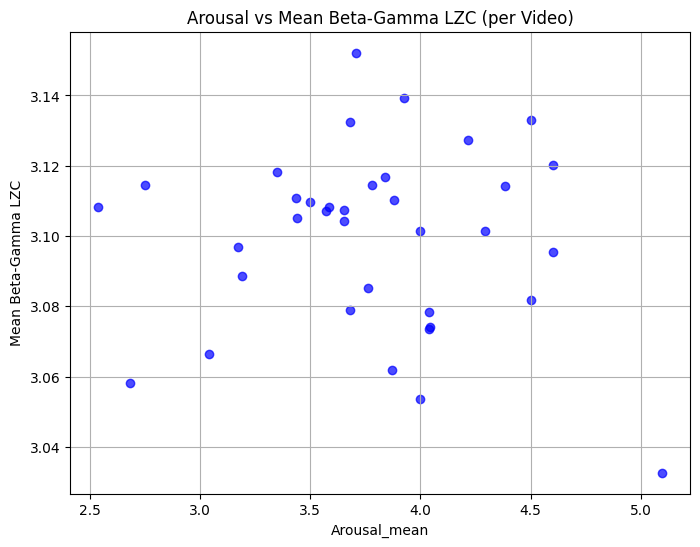

Linear regression: mean_beta_gamma ~ Arousal_mean
Coefficient: -0.0037
Intercept: 3.1133
R^2: 0.0063
MSE: 0.0006
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.2148
Date:                Tue, 02 Dec 2025   Prob (F-statistic):              0.646
Time:                        16:53:15   Log-Likelihood:                 81.138
No. Observations:                  36   AIC:                            -158.3
Df Residuals:                      34   BIC:                            -155.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [508]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(combined_per_video_df["Arousal_mean"], combined_per_video_df["mean_beta_gamma"], c='blue', alpha=0.7)
plt.xlabel("Arousal_mean")
plt.ylabel("Mean Beta-Gamma LZC")
plt.title("Arousal vs Mean Beta-Gamma LZC (per Video)")
plt.grid(True)
plt.show()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Prepare variables for regression
X = combined_per_video_df[["Arousal_mean"]].values
y = combined_per_video_df["mean_beta_gamma"].values

# Fit linear regression
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

# Calculate statistics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
coef = reg.coef_[0]
intercept = reg.intercept_

# Print regression statistics
print("Linear regression: mean_beta_gamma ~ Arousal_mean")
print(f"Coefficient: {coef:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")

# If you want more detailed stats, use statsmodels
import statsmodels.api as sm
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
results = model.fit()
print(results.summary())


In [509]:
from scipy.stats import pearsonr

corr_results = []

for band in bands:
    # Now: Predict lzc from arousal/valence, i.e., lzc ~ arousal_mean
    r, p = pearsonr(combined_per_video_df["Arousal_mean"], combined_per_video_df[band])
    corr_results.append({
        "Band": band,
        "Predictor": "Arousal_mean",
        "Outcome": band,
        "Pearson_r": r,
        "P_value": p
    })

for band in bands:
    r, p = pearsonr(combined_per_video_df["Valence_mean"], combined_per_video_df[band])
    corr_results.append({
        "Band": band,
        "Predictor": "Valence_mean",
        "Outcome": band,
        "Pearson_r": r,
        "P_value": p
    })

corr_df = pd.DataFrame(corr_results)
corr_df

,Band,Predictor,Outcome,Pearson_r,P_value
0,delta,Arousal_mean,delta,-0.128213,0.456143
1,theta,Arousal_mean,theta,-0.080942,0.638866
2,alpha1,Arousal_mean,alpha1,-0.308595,0.067069
3,alpha2,Arousal_mean,alpha2,-0.367732,0.027350
4,beta1,Arousal_mean,beta1,-0.106601,0.536046
5,beta2,Arousal_mean,beta2,-0.103605,0.547633
6,gamma1,Arousal_mean,gamma1,-0.106728,0.535559
7,gamma2,Arousal_mean,gamma2,-0.105657,0.539683
8,mean_beta_gamma,Arousal_mean,mean_beta_gamma,-0.079227,0.646010
9,alpha_mean,Arousal_mean,alpha_mean,-0.564387,0.000337


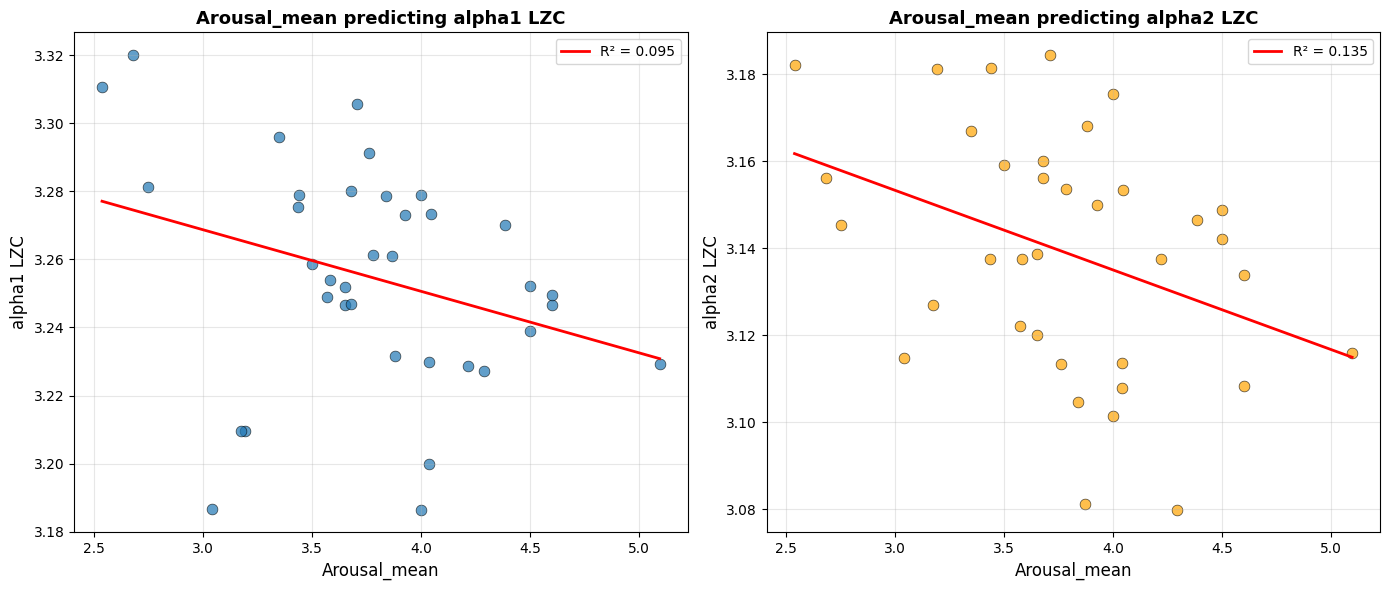

Regression Statistics:

Arousal_mean predicting alpha1:
  Coefficient: -0.0181
  Intercept: 3.3230
  R²: 0.0952
  N: 36

Arousal_mean predicting alpha2:
  Coefficient: -0.0183
  Intercept: 3.2083
  R²: 0.1352
  N: 36


In [510]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Create figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Arousal_mean predicting alpha1
ax1 = axes[0]
x1 = combined_per_video_df["Arousal_mean"].values  # Independent variable
y1 = combined_per_video_df["alpha1"].values  # Dependent variable

# Remove NaN values
mask1 = ~(np.isnan(x1) | np.isnan(y1))
x1_clean = x1[mask1]
y1_clean = y1[mask1]

# Scatter plot
ax1.scatter(x1_clean, y1_clean, alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

# Fit regression line (predicting alpha1 from Arousal_mean)
if len(x1_clean) > 0:
    reg1 = LinearRegression()
    reg1.fit(x1_clean.reshape(-1, 1), y1_clean)
    y1_pred = reg1.predict(x1_clean.reshape(-1, 1))
    
    # Sort for plotting regression line smoothly
    sort_idx = np.argsort(x1_clean)
    x1_sorted = x1_clean[sort_idx]
    y1_pred_sorted = y1_pred[sort_idx]
    
    # Plot regression line
    ax1.plot(x1_sorted, y1_pred_sorted, 'r-', linewidth=2, label=f'R² = {reg1.score(x1_clean.reshape(-1, 1), y1_clean):.3f}')
    ax1.legend()

ax1.set_xlabel('Arousal_mean', fontsize=12)
ax1.set_ylabel('alpha1 LZC', fontsize=12)
ax1.set_title('Arousal_mean predicting alpha1 LZC', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Arousal_mean predicting alpha2
ax2 = axes[1]
x2 = combined_per_video_df["Arousal_mean"].values  # Independent variable
y2 = combined_per_video_df["alpha2"].values  # Dependent variable

# Remove NaN values
mask2 = ~(np.isnan(x2) | np.isnan(y2))
x2_clean = x2[mask2]
y2_clean = y2[mask2]

# Scatter plot
ax2.scatter(x2_clean, y2_clean, alpha=0.7, s=60, edgecolors='black', linewidth=0.5, color='orange')

# Fit regression line (predicting alpha2 from Arousal_mean)
if len(x2_clean) > 0:
    reg2 = LinearRegression()
    reg2.fit(x2_clean.reshape(-1, 1), y2_clean)
    y2_pred = reg2.predict(x2_clean.reshape(-1, 1))
    
    # Sort for plotting regression line smoothly
    sort_idx = np.argsort(x2_clean)
    x2_sorted = x2_clean[sort_idx]
    y2_pred_sorted = y2_pred[sort_idx]
    
    # Plot regression line
    ax2.plot(x2_sorted, y2_pred_sorted, 'r-', linewidth=2, label=f'R² = {reg2.score(x2_clean.reshape(-1, 1), y2_clean):.3f}')
    ax2.legend()

ax2.set_xlabel('Arousal_mean', fontsize=12)
ax2.set_ylabel('alpha2 LZC', fontsize=12)
ax2.set_title('Arousal_mean predicting alpha2 LZC', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print regression statistics
print("Regression Statistics:")
print("="*60)
print(f"\nArousal_mean predicting alpha1:")
if len(x1_clean) > 0:
    print(f"  Coefficient: {reg1.coef_[0]:.4f}")
    print(f"  Intercept: {reg1.intercept_:.4f}")
    print(f"  R²: {reg1.score(x1_clean.reshape(-1, 1), y1_clean):.4f}")
    print(f"  N: {len(x1_clean)}")

print(f"\nArousal_mean predicting alpha2:")
if len(x2_clean) > 0:
    print(f"  Coefficient: {reg2.coef_[0]:.4f}")
    print(f"  Intercept: {reg2.intercept_:.4f}")
    print(f"  R²: {reg2.score(x2_clean.reshape(-1, 1), y2_clean):.4f}")
    print(f"  N: {len(x2_clean)}")


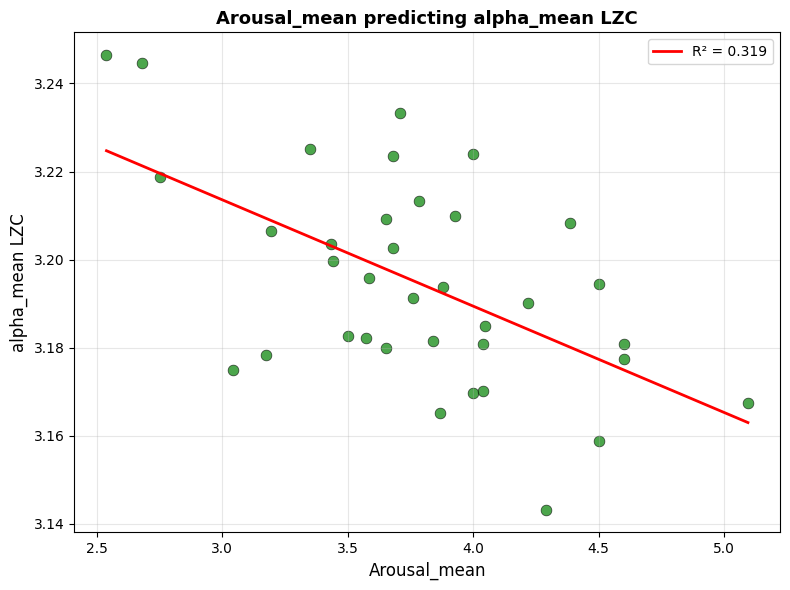

Regression Statistics:

Arousal_mean predicting alpha_mean:
  Coefficient: -0.0242
  Intercept: 3.2860
  R²: 0.3185
  N: 36


In [511]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Calculate alpha_mean if it doesn't exist in combined_per_video_df
if 'alpha_mean' not in combined_per_video_df.columns:
    combined_per_video_df['alpha_mean'] = combined_per_video_df[['alpha1', 'alpha2']].mean(axis=1)

# Create scatter plot for alpha_mean
plt.figure(figsize=(8, 6))

# Arousal_mean predicting alpha_mean
x = combined_per_video_df["Arousal_mean"].values  # Independent variable
y = combined_per_video_df["alpha_mean"].values  # Dependent variable

# Remove NaN values
mask = ~(np.isnan(x) | np.isnan(y))
x_clean = x[mask]
y_clean = y[mask]

# Scatter plot
plt.scatter(x_clean, y_clean, alpha=0.7, s=60, edgecolors='black', linewidth=0.5, color='green')

# Fit regression line (predicting alpha_mean from Arousal_mean)
if len(x_clean) > 0:
    reg = LinearRegression()
    reg.fit(x_clean.reshape(-1, 1), y_clean)
    y_pred = reg.predict(x_clean.reshape(-1, 1))
    
    # Sort for plotting regression line smoothly
    sort_idx = np.argsort(x_clean)
    x_sorted = x_clean[sort_idx]
    y_pred_sorted = y_pred[sort_idx]
    
    # Plot regression line
    plt.plot(x_sorted, y_pred_sorted, 'r-', linewidth=2, label=f'R² = {reg.score(x_clean.reshape(-1, 1), y_clean):.3f}')
    plt.legend()

plt.xlabel('Arousal_mean', fontsize=12)
plt.ylabel('alpha_mean LZC', fontsize=12)
plt.title('Arousal_mean predicting alpha_mean LZC', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print regression statistics
print("Regression Statistics:")
print("="*60)
print(f"\nArousal_mean predicting alpha_mean:")
if len(x_clean) > 0:
    print(f"  Coefficient: {reg.coef_[0]:.4f}")
    print(f"  Intercept: {reg.intercept_:.4f}")
    print(f"  R²: {reg.score(x_clean.reshape(-1, 1), y_clean):.4f}")
    print(f"  N: {len(x_clean)}")


Columns in combined_df:
Index(['Participant_ID', 'Video_ID', 'Valence', 'Arousal', 'delta', 'theta',
       'alpha1', 'alpha2', 'beta1', 'beta2', 'gamma1', 'gamma2',
       'mean_beta_gamma', 'alpha_mean'],
      dtype='object')

Rows after dropping NaNs: 865
  Participant_ID  Video_ID  Arousal  alpha_mean
0              1         1      1.0    3.117647
1              1         2      3.0    2.954545
2              1         3      1.0    3.203704
3              1         5      4.0    3.010000
4              1         7      3.0    2.355556

Example of z-scored data:
  Participant_ID  Video_ID  Arousal  alpha_mean  Arousal_z  alpha_mean_z
0              1         1      1.0    3.117647  -1.289652      0.315369
1              1         2      3.0    2.954545   0.064483     -0.324629
2              1         3      1.0    3.203704  -1.289652      0.653048
3              1         5      4.0    3.010000   0.741550     -0.107030
4              1         7      3.0    2.355556   0.064483  

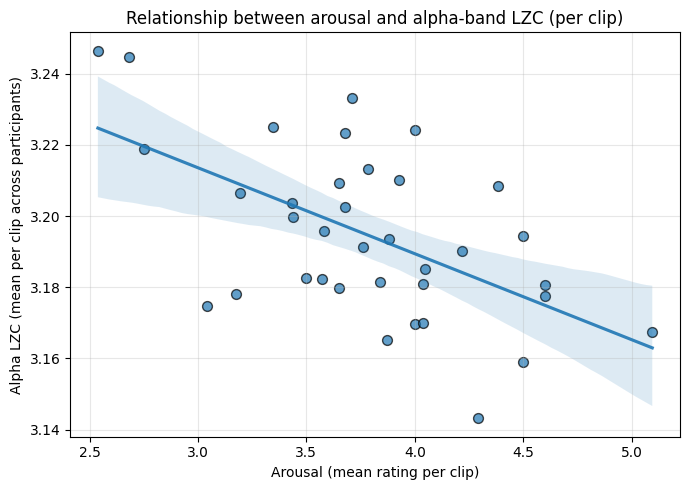

In [516]:
# -------------------------------------------------------------------
# 0. Assumption: you already have `combined_df`
#    with columns:
#    ['Participant_ID', 'Video_ID', 'Arousal',
#     'delta','theta','alpha1','alpha2','beta1','beta2','gamma1','gamma2', ...]
# -------------------------------------------------------------------

print("Columns in combined_df:")
print(combined_df.columns)

# -------------------------------------------------------------------
# 1. Create a single alpha measure (mean of alpha1 and alpha2)
# -------------------------------------------------------------------
combined_df["alpha_mean"] = combined_df[["alpha1", "alpha2"]].mean(axis=1)

# Keep only the columns needed for this analysis
model_df = combined_df[["Participant_ID", "Video_ID", "Arousal", "alpha_mean"]].copy()

# Drop rows with missing Arousal or alpha_mean
model_df = model_df.dropna(subset=["Arousal", "alpha_mean"])

print(f"\nRows after dropping NaNs: {len(model_df)}")
print(model_df.head())

# -------------------------------------------------------------------
# 2. Within-participant z-scoring for Arousal and alpha_mean
#    This makes the effect "within-person": deviations from each
#    participant's own average.
# -------------------------------------------------------------------
grouped = model_df.groupby("Participant_ID")

model_df["Arousal_z"] = grouped["Arousal"].transform(
    lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9)
)
model_df["alpha_mean_z"] = grouped["alpha_mean"].transform(
    lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9)
)

print("\nExample of z-scored data:")
print(model_df[["Participant_ID", "Video_ID", "Arousal", "alpha_mean",
                "Arousal_z", "alpha_mean_z"]].head())

# -------------------------------------------------------------------
# 3. Mixed model:
#    Arousal_z ~ alpha_mean_z + fixed effect of Video_ID
#    Random intercept per Participant_ID
# -------------------------------------------------------------------
formula = "Arousal_z ~ alpha_mean_z + C(Video_ID)"

alpha_model = smf.mixedlm(
    formula,
    data=model_df,
    groups=model_df["Participant_ID"]  # random intercept for participants
)
alpha_result = alpha_model.fit(reml=True)

print("\n=== Mixed model summary (Arousal_z ~ alpha_mean_z + C(Video_ID)) ===")
print(alpha_result.summary())

# -------------------------------------------------------------------
# 4. Compact table for the alpha_mean_z effect
#    (beta, SE, z, p, 95% CI, N trials, N participants)
# -------------------------------------------------------------------
beta = alpha_result.params["alpha_mean_z"]
se = alpha_result.bse["alpha_mean_z"]
z = beta / se
p = alpha_result.pvalues["alpha_mean_z"]
ci_low = beta - 1.96 * se
ci_high = beta + 1.96 * se

summary_table = pd.DataFrame({
    "term": ["alpha_mean_z"],
    "beta": [beta],
    "SE": [se],
    "z": [z],
    "p": [p],
    "CI_low_95": [ci_low],
    "CI_high_95": [ci_high],
    "N_trials": [len(model_df)],
    "N_participants": [model_df["Participant_ID"].nunique()],
})

print("\n=== Compact summary for alpha_mean_z effect ===")
print(summary_table.round(3))

# -------------------------------------------------------------------
# 5. Per-video aggregation for an easy-to-read scatter plot:
#    mean alpha_mean and mean Arousal per clip
#    Using combined_per_video_df which already has outliers removed
# -------------------------------------------------------------------

# Ensure alpha_mean exists in combined_per_video_df
if 'alpha_mean' not in combined_per_video_df.columns:
    combined_per_video_df['alpha_mean'] = combined_per_video_df[['alpha1', 'alpha2']].mean(axis=1)

# Use combined_per_video_df directly (already has outliers removed)
video_alpha_df = combined_per_video_df[['Video_ID', 'Arousal_mean', 'alpha_mean', 'N_participants']].copy()

# Rename alpha_mean to alpha_mean_per_video for consistency
video_alpha_df = video_alpha_df.rename(columns={
    "alpha_mean": "alpha_mean_per_video"
})

print("\n=== Per-video alpha & arousal means (first few clips) ===")
print(video_alpha_df.head())

# -------------------------------------------------------------------
# 6. Clip-level correlation between mean alpha LZC and mean arousal
# -------------------------------------------------------------------
r, p_corr = pearsonr(video_alpha_df["Arousal_mean"],
                     video_alpha_df["alpha_mean_per_video"])

print(f"\nClip-level Pearson r (Arousal_mean vs alpha_mean_per_video): "
      f"r = {r:.3f}, p = {p_corr:.3f}")

# -------------------------------------------------------------------
# 7. Plot: per-video Arousal_mean vs alpha_mean with regression line
#    This is the "easy to visually analyze" main figure.
# -------------------------------------------------------------------
plt.figure(figsize=(7, 5))
sns.regplot(
    x="Arousal_mean",
    y="alpha_mean_per_video",
    data=video_alpha_df,
    scatter_kws=dict(alpha=0.7, s=50, edgecolor="black"),
    line_kws=dict(alpha=0.9)
)
plt.xlabel("Arousal (mean rating per clip)")
plt.ylabel("Alpha LZC (mean per clip across participants)")
plt.title("Relationship between arousal and alpha-band LZC (per clip)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [513]:
# Aggregate data by averaging across videos instead of participants

# Aggregation dictionary
agg_dict = {
    "Arousal": "mean",
    "Valence": "mean",
    "Video_ID": "nunique",  # how many videos each participant rated
}

for band in bands:
    agg_dict[band] = "mean"

combined_per_participant_df = combined_df.groupby("Participant_ID").agg(agg_dict).reset_index()

# Rename columns to be explicit
combined_per_participant_df = combined_per_participant_df.rename(columns={
    "Arousal": "Arousal_mean",
    "Valence": "Valence_mean",
    "Video_ID": "N_videos"
})

combined_per_participant_df

,Participant_ID,Arousal_mean,Valence_mean,N_videos,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2,mean_beta_gamma,alpha_mean
0,1,2.904762,0.047619,21,8.294353,3.059360,3.042115,3.032437,3.050291,3.020558,3.044040,3.031411,3.036575,3.037276
1,10,3.666667,0.111111,18,8.200836,3.106982,3.125568,3.127073,3.162925,3.056578,3.195773,3.111749,3.131756,3.126321
2,11,3.666667,-0.250000,12,8.166004,2.968934,2.939399,2.887237,2.768522,2.821710,2.774203,2.963390,2.831956,2.913318
3,12,3.636364,0.272727,22,7.760005,3.167172,3.148603,3.072510,3.060994,3.026729,3.082225,3.051383,3.055333,3.110557
4,15,3.750000,-0.416667,12,8.012605,3.091674,3.100611,3.041356,3.031694,3.042961,3.048380,3.043417,3.041613,3.070983
5,16,4.440000,0.280000,25,7.930530,3.156128,3.167184,3.010282,2.974974,3.075103,2.636436,3.070511,2.939256,3.088733
6,17,4.000000,0.125000,8,7.592990,3.169321,3.161256,3.047579,3.040724,2.939290,3.039767,3.027399,3.011795,3.104418
7,19,4.363636,0.818182,33,8.519987,3.258654,3.292484,3.065134,3.109744,3.085083,3.118699,3.108199,3.105431,3.178809
8,2,3.741935,0.451613,31,8.276642,3.124945,3.168349,3.056229,3.068867,3.013155,3.108805,3.118180,3.077252,3.112289
9,20,4.611111,-0.055556,36,8.483231,3.208179,3.231193,3.088207,3.135248,3.029445,3.131600,3.076597,3.093222,3.159700


In [514]:
# Summary table of correlation between arousal and each band when averaged across videos

corr_results = []

for band in bands:
    # Now: Predict lzc from arousal/valence, i.e., lzc ~ arousal_mean
    r, p = pearsonr(combined_per_participant_df["Arousal_mean"], combined_per_participant_df[band])
    corr_results.append({
        "Band": band,
        "Predictor": "Arousal_mean",
        "Outcome": band,
        "Pearson_r": r,
        "P_value": p
    })

for band in bands:
    r, p = pearsonr(combined_per_participant_df["Valence_mean"], combined_per_participant_df[band])
    corr_results.append({
        "Band": band,
        "Predictor": "Valence_mean",
        "Outcome": band,
        "Pearson_r": r,
        "P_value": p
    })

corr_df = pd.DataFrame(corr_results)
corr_df

,Band,Predictor,Outcome,Pearson_r,P_value
0,delta,Arousal_mean,delta,-0.144755,0.429263
1,theta,Arousal_mean,theta,-0.023807,0.897093
2,alpha1,Arousal_mean,alpha1,-0.053126,0.772756
3,alpha2,Arousal_mean,alpha2,-0.060983,0.740225
4,beta1,Arousal_mean,beta1,-0.132971,0.468146
5,beta2,Arousal_mean,beta2,0.165323,0.365867
6,gamma1,Arousal_mean,gamma1,-0.170833,0.349877
7,gamma2,Arousal_mean,gamma2,-0.032061,0.861712
8,mean_beta_gamma,Arousal_mean,mean_beta_gamma,-0.091717,0.617610
9,alpha_mean,Arousal_mean,alpha_mean,-0.061862,0.736612
